## In this notebook, we will train a convolutional neural network to segment our satellite images.  We will first use our raw images, and then compare with extra features from previous engineering, such as as dsm with tophat filtering and nvdi.  Once as benchmark is set, we will look into hyperparameter optimization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from preprocessing.preprocessor import Preprocess     #  From usatellite
from models.unet2d.unet2d_model import Unet2d         #  From usatellite
from plot_utils.plotting_utils import SatPlotter      #  From usatellite

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import backend as K

from tensorflow.keras.optimizers import Adam
from loss.loss_metrics import Loss

## First we will load our data.  

In [2]:
imgs_array = np.load('/Users/cody/Python/usattelite_data/img_array.npy')

In [3]:
dsm_array = np.load('/Users/cody/Python/usattelite_data/dsm_array.npy')

In [4]:
nvdi_array = np.load('/Users/cody/Python/usattelite_data/veggies_array.npy')

In [5]:
label_array = np.load('/Users/cody/Python/usattelite_data/label_array.npy')

Let's just start with our images as input to the network to provide a benchmark...  Later we will create more complex data structures, which contain more than just rgb.  These data will add the dsm and/or nvdi images as extra channels.

Let's scale our data, since that is typically helpful for machine learning.

In [6]:
preproc = Preprocess()

In [7]:
imgs_array_scaled = preproc.unit_normalize_dims(imgs_array)

I'm actually going to just use sklearn's train test split to split up the data into traing and test data - there's really no reason to write our own code for this.  We will also shuffle the data and set a random state so it's reproducible.

In [8]:
x_train, x_val, y_train, y_val = train_test_split(imgs_array, label_array, test_size=0.30, shuffle=True, random_state=42)

In [9]:
unet2dmodel = Unet2d(input_img=imgs_array)

In [10]:
unet2dmodel_obj = unet2dmodel.get_unet()

In [11]:
unet2dmodel_obj.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=["categorical_accuracy", Loss.f1])

results = unet2dmodel_obj.fit(x_train, y_train, batch_size=6, epochs=100, callbacks=unet2dmodel.callback_list(),
                   validation_data=(x_val, y_val))

In [12]:
loaded_result = unet2dmodel_obj.load_weights('model-test-5.h5')

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(loaded_result.history["f1"], label="f1")
plt.plot(loaded_result.history["val_f1"], label="val_f1")
#plt.plot( np.argmin(results.history["val_f1"]), np.min(results.history["val_f1"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### It looks like the model was able to understand the images and context.

In [13]:
test_imgs = unet2dmodel_obj.predict(x_val)

In [14]:
test_classes = np.argmax(test_imgs, -1)

In [15]:
unet2dmodel_obj.evaluate(x_val, y_val, verbose=1)

1/1 [==============================] - 0s 2ms/step - loss: 0.9195 - categorical_accuracy: 0.7940 - f1: 0.7259


[0.9194549322128296, 0.7940475344657898, 0.7258614301681519]

In [16]:
satplot = SatPlotter()

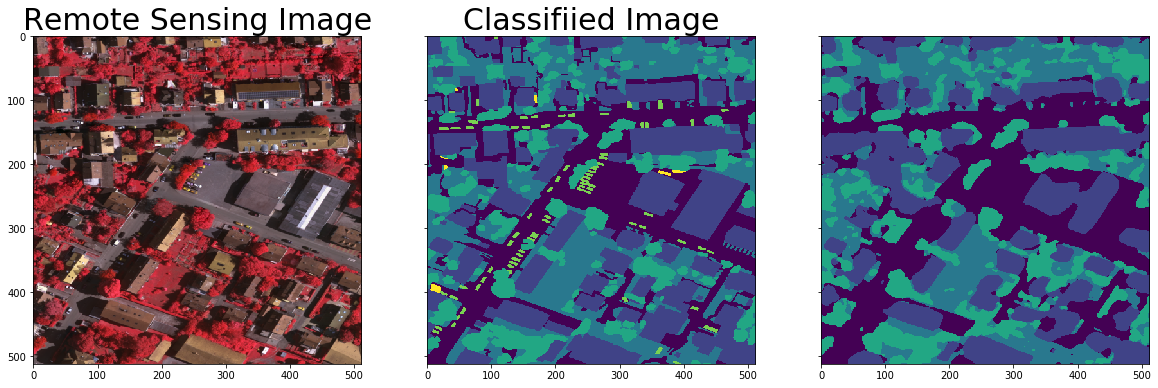

In [17]:
satplot.plot_image_and_result(x_val, y_val, test_classes)